In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn # 인공 신경망 모델들 모아놓은 모듈
import torch.nn.functional as F #그중 자주 쓰이는것들을 F로
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
from glob import glob
import sys
from sklearn.model_selection import train_test_split # train , test 분리에 사용.

if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
#DEVICE = torch.device('cpu')
print('Using Pytorch version : ',torch.__version__,' Device : ',DEVICE)

Using Pytorch version :  1.10.2  Device :  cuda


In [3]:
from tqdm import tqdm
import pywt
from datetime import datetime

In [4]:
#우선 교차검증 시 데이터 분할이 어떻게 이루어지는지 그려 볼 수 있게 해주는 helper function을 가져오자.
from sklearn.model_selection import TimeSeriesSplit 
from matplotlib.patches import Patch
import matplotlib.pyplot as plt 

cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
plt.style.use('fivethirtyeight')


def plot_cv_indices(cv, X, n_splits, lw=10):
    
    fig, ax = plt.subplots()
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    # Formatting
    yticklabels = list(range(n_splits))
    ax.set(yticks=np.arange(n_splits) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+0.1, -.1], xlim=[0, len(X)])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    
    ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
          ['Testing set', 'Training set'], loc=(1.02, .8))

# 데이터 전처리

```

TurbID - 발전기 ID

Day - 날짜

Tmstamp - 시간

Wspd - 풍속

Wdir - 터빈이 바라보는 각도와 실제 바람 방향 각도 차이

Etmp - 외부 온도

Itmp - 터빈 내부 온도

Ndir - 터빈이 바라보는 방향 각도

Pab - 터빈 당 3개의 날이 있으며 각각의 각도가 다름

Prtv - 무효전력 : 에너지원을 필요로 하지 않는 전력

Patv - 유효전력 : 실제로 터빈을 돌리는 일을 하는 전력

````


베이스 라인 제공 전처리 방법

In [5]:
train_data = pd.read_csv("data/train_data.csv")
new_data = pd.read_csv("data/newdata.csv")


sample_submission = pd.read_csv("data/sample_submission.csv")

In [6]:
new_data=new_data[(new_data['Day']==201) | (new_data['Day']==202)]

In [7]:
# train_data의 결측값 확인
train_data.isnull().sum()

TurbID         0
Day            0
Tmstamp        0
Wspd       45587
Wdir       45587
Etmp       45587
Itmp       45587
Ndir       45587
Pab1       45587
Pab2       45587
Pab3       45587
Prtv       45587
Patv       45587
dtype: int64

In [8]:
new_data = new_data.fillna(method="ffill").fillna(method='bfill')
new_data.isnull().sum()

TurbID     0
Day        0
Tmstamp    0
Wspd       0
Wdir       0
Etmp       0
Itmp       0
Ndir       0
Pab1       0
Pab2       0
Pab3       0
Prtv       0
Patv       0
dtype: int64

# 기타 전처리

In [9]:
df_updated = train_data.copy()

In [10]:
df = df_updated[['TurbID', 'Day', 'Tmstamp', 'Wspd', 'Wdir', 'Etmp', 'Itmp', 'Ndir', 'Pab1', 'Pab2', 'Pab3', 'Prtv', 'Patv']].copy()
df.head()

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,1,00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,00:10,6.17,-3.99,30.73,41.80,25.92,1.0,1.0,1.0,-0.25,494.66
2,1,1,00:20,6.27,-2.18,30.60,41.63,20.91,1.0,1.0,1.0,-0.24,509.76
3,1,1,00:30,6.42,-0.73,30.52,41.52,20.91,1.0,1.0,1.0,-0.26,542.53
4,1,1,00:40,6.25,0.89,30.49,41.38,20.91,1.0,1.0,1.0,-0.23,509.36


In [11]:
df['Tmstamp'][0].split(':')

['00', '00']

In [12]:
a, b = df['Tmstamp'][20].split(':')
a, b

('03', '20')

In [13]:
def make_hour(values):
    a, b = values.split(':')
    
    return int(a)

df['hour'] = df['Tmstamp'].apply(lambda x: make_hour(x))   

In [14]:
def make_minute(values):
    a, b = values.split(':')
    if b == '00':
        return 0
    elif b== '10':
        return 1
    elif b== '20':
        return 2
    elif b== '30':
        return 3
    elif b== '40':
        return 4
    elif b== '50':
        return 5

df['minute'] = df['Tmstamp'].apply(lambda x: make_minute(x))

In [15]:
# 순서 넘겨주기.
df = df[['TurbID', 'Day', 'Tmstamp', 'hour', 'minute', 'Wspd', 'Wdir', 'Etmp', 'Itmp', 'Ndir', 'Pab1', 'Pab2', 'Pab3', 'Prtv', 'Patv']]

In [16]:
# method : 결측값을 변경할 방식입니다. bfill로 할경우 결측값을 바로 아래 값과 동일하게 변경합니다.
# 결측값 처리
#train_data = train_data.fillna(method = 'ffill').fillna(method = 'bfill')

print(train_data.isnull().sum())

TurbID         0
Day            0
Tmstamp        0
Wspd       45587
Wdir       45587
Etmp       45587
Itmp       45587
Ndir       45587
Pab1       45587
Pab2       45587
Pab3       45587
Prtv       45587
Patv       45587
dtype: int64


In [17]:
train_data = df.copy()
train_data

,TurbID,Day,Tmstamp,hour,minute,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,1,00:00,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,00:10,0,1,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
2,1,1,00:20,0,2,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76
3,1,1,00:30,0,3,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53
4,1,1,00:40,0,4,6.25,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3859195,134,200,23:10,23,1,4.86,4.68,9.04,10.40,174.39,0.01,0.01,0.01,-108.13,308.65
3859196,134,200,23:20,23,2,4.46,-4.00,8.79,10.33,179.76,0.01,0.01,0.01,-93.64,221.60
3859197,134,200,23:30,23,3,4.23,-0.08,8.74,10.22,172.35,0.01,0.01,0.01,-111.20,220.60
3859198,134,200,23:40,23,4,4.36,-6.12,8.64,10.10,172.35,0.01,0.01,0.01,-108.04,222.15


In [18]:
# Feature 중 Tmstamp 정수로 변환
tms_list = list(pd.unique(train_data["Tmstamp"]))

train_data["Tmstamp"] = train_data["Tmstamp"].apply(lambda x : tms_list.index(x))

In [19]:
df = train_data.copy()

In [20]:
df = df.sort_values(by=['hour', 'Day', 'TurbID', 'minute'])
df.reset_index(drop=True, inplace=True)
df

,TurbID,Day,Tmstamp,hour,minute,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,1,0,1,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
2,1,1,2,0,2,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76
3,1,1,3,0,3,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53
4,1,1,4,0,4,6.25,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3859195,134,200,139,23,1,4.86,4.68,9.04,10.40,174.39,0.01,0.01,0.01,-108.13,308.65
3859196,134,200,140,23,2,4.46,-4.00,8.79,10.33,179.76,0.01,0.01,0.01,-93.64,221.60
3859197,134,200,141,23,3,4.23,-0.08,8.74,10.22,172.35,0.01,0.01,0.01,-111.20,220.60
3859198,134,200,142,23,4,4.36,-6.12,8.64,10.10,172.35,0.01,0.01,0.01,-108.04,222.15


In [21]:
df = df.interpolate()
df = df.fillna(method='bfill')

In [22]:
df.isnull().sum()

TurbID     0
Day        0
Tmstamp    0
hour       0
minute     0
Wspd       0
Wdir       0
Etmp       0
Itmp       0
Ndir       0
Pab1       0
Pab2       0
Pab3       0
Prtv       0
Patv       0
dtype: int64

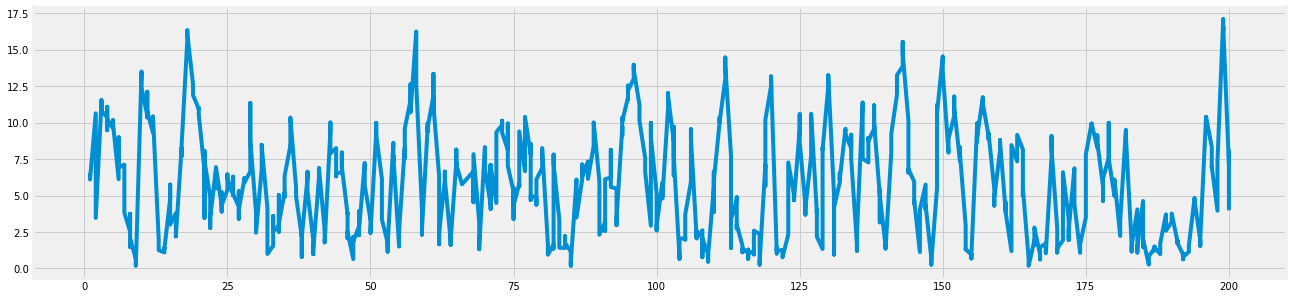

In [23]:
# Tmstamp 당 Patv 추세를 확인.
plt.figure(figsize=(20, 5))
#j = 201 # Day
j = 0 # hour
for i in range(1, 2): # TurbID / group 6
    plt.plot(df[(df['TurbID']==i) & (df['hour']==j)]['Day'], df[(df['TurbID']==i) & (df['hour']==j)]['Wspd'])
    #plt.plot(train_data[(train_data['TurbID']==i)]['Day'], train_data[(train_data['TurbID']==i)]['Patv'])
    #plt.xticks([])
# k = 21 # turb id
# plt.plot(df1[(df1['TurbID']==k) & (df1['Day']==j)]['Tmstamp'], df1[(df1['TurbID']==k) & (df1['Day']==j)]['Patv'], linewidth=5.0)
#    plt.title(f'TurbID : 1, Day:{i}')

In [24]:
train_data = df.copy()
train_data

,TurbID,Day,Tmstamp,hour,minute,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,1,0,0,0,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
1,1,1,1,0,1,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
2,1,1,2,0,2,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76
3,1,1,3,0,3,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53
4,1,1,4,0,4,6.25,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3859195,134,200,139,23,1,4.86,4.68,9.04,10.40,174.39,0.01,0.01,0.01,-108.13,308.65
3859196,134,200,140,23,2,4.46,-4.00,8.79,10.33,179.76,0.01,0.01,0.01,-93.64,221.60
3859197,134,200,141,23,3,4.23,-0.08,8.74,10.22,172.35,0.01,0.01,0.01,-111.20,220.60
3859198,134,200,142,23,4,4.36,-6.12,8.64,10.10,172.35,0.01,0.01,0.01,-108.04,222.15


In [25]:
train_data = train_data.sort_values(by=['TurbID', 'Day', 'hour', 'minute'])
train_data.reset_index(drop=True, inplace=True)
train_data

,TurbID,Day,Tmstamp,hour,minute,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,1,0,0,0,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
1,1,1,1,0,1,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
2,1,1,2,0,2,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76
3,1,1,3,0,3,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53
4,1,1,4,0,4,6.25,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3859195,134,200,139,23,1,4.86,4.68,9.04,10.40,174.39,0.01,0.01,0.01,-108.13,308.65
3859196,134,200,140,23,2,4.46,-4.00,8.79,10.33,179.76,0.01,0.01,0.01,-93.64,221.60
3859197,134,200,141,23,3,4.23,-0.08,8.74,10.22,172.35,0.01,0.01,0.01,-111.20,220.60
3859198,134,200,142,23,4,4.36,-6.12,8.64,10.10,172.35,0.01,0.01,0.01,-108.04,222.15


In [27]:
del df

----

In [28]:
# Y value 추가
train_data['Wspd_y']=train_data['Wspd']

In [ ]:
train_data[(train_data["TurbID"]==1)&(train_data["Day"]==1)]

In [130]:


#x = np.array(train_data['Wspd'])
#(ca, cd) = pywt.dwt(x, "haar")
#cat = pywt.threshold(ca, np.std(ca), mode="soft")
#cdt = pywt.threshold(cd, np.std(cd), mode="soft")
#tx = pywt.idwt(cat, cdt, "haar")

In [131]:
#train_data['Wspd']=tx

In [29]:
train_data

,TurbID,Day,Tmstamp,hour,minute,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv,Wspd_y
0,1,1,0,0,0,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66,6.17
1,1,1,1,0,1,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66,6.17
2,1,1,2,0,2,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76,6.27
3,1,1,3,0,3,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53,6.42
4,1,1,4,0,4,6.25,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36,6.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3859195,134,200,139,23,1,4.86,4.68,9.04,10.40,174.39,0.01,0.01,0.01,-108.13,308.65,4.86
3859196,134,200,140,23,2,4.46,-4.00,8.79,10.33,179.76,0.01,0.01,0.01,-93.64,221.60,4.46
3859197,134,200,141,23,3,4.23,-0.08,8.74,10.22,172.35,0.01,0.01,0.01,-111.20,220.60,4.23
3859198,134,200,142,23,4,4.36,-6.12,8.64,10.10,172.35,0.01,0.01,0.01,-108.04,222.15,4.36


In [133]:
# 1차분 변수 추가.
#train_data['Wspd_1']=0

#for turb in tqdm(range(1,135)):
#    train_data.loc[train_data['TurbID']==turb,'Wspd_1']=train_data.loc[train_data['TurbID']==turb,'Wspd']-train_data.loc[train_data['TurbID']==turb,'Wspd'].shift().fillna(method='bfill')




100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [00:01<00:00, 93.97it/s]


In [322]:
#pab 추가 변수

train_data['Pab_over'] = 0

train_data.loc[train_data['Pab1']>=89,'Pab_over'] = 1
train_data.loc[train_data['Pab2']>=89,'Pab_over'] = 1
train_data.loc[train_data['Pab3']>=89,'Pab_over'] = 1


In [134]:
train_data.describe()

,TurbID,Day,Tmstamp,hour,minute,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv,Wspd_y,Wspd_1
count,3.859200e+06,3.859200e+06,3.859200e+06,3.859200e+06,3.859200e+06,3.859200e+06,3.859200e+06,3.859200e+06,3.859200e+06,3.859200e+06,3.859200e+06,3.859200e+06,3.859200e+06,3.859200e+06,3.859200e+06,3.859200e+06,3.859200e+06
mean,6.750000e+01,1.005000e+02,7.150000e+01,1.150000e+01,2.500000e+00,2.332244e+00,2.614239e-01,4.572761e+01,3.132578e+01,1.841302e+02,2.581436e+01,2.579058e+01,2.577532e+01,-1.489652e+01,3.586304e+02,5.232055e+00,-3.976323e-05
std,3.868140e+01,5.773431e+01,4.156822e+01,6.922187e+00,1.707825e+00,2.937137e+00,2.987438e+01,8.394415e+01,1.716360e+01,1.671287e+02,3.813392e+01,3.812350e+01,3.811421e+01,7.072748e+01,4.249115e+02,3.446809e+00,6.526820e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.978181e+00,-3.030460e+03,-2.730300e+02,-2.731700e+02,-8.848600e+02,-1.000000e+01,-1.000000e+01,-1.000000e+01,-6.249800e+02,0.000000e+00,0.000000e+00,-1.476924e+01
25%,3.400000e+01,5.075000e+01,3.575000e+01,5.750000e+00,1.000000e+00,0.000000e+00,-3.810000e+00,2.069000e+01,2.611000e+01,5.112000e+01,1.000000e-02,1.000000e-02,1.000000e-02,-4.070000e+01,0.000000e+00,2.440000e+00,0.000000e+00
50%,6.750000e+01,1.005000e+02,7.150000e+01,1.150000e+01,2.500000e+00,1.151439e+00,-2.400000e-01,2.829000e+01,3.279000e+01,1.909200e+02,6.500000e-01,6.500000e-01,6.495154e-01,-3.200000e-01,1.921600e+02,4.570000e+00,0.000000e+00
75%,1.010000e+02,1.502500e+02,1.072500e+02,1.725000e+01,4.000000e+00,3.836439e+00,3.350000e+00,3.389000e+01,3.819000e+01,3.211744e+02,7.687000e+01,7.650000e+01,7.629000e+01,-2.200000e-01,5.627400e+02,7.270000e+00,0.000000e+00
max,1.340000e+02,2.000000e+02,1.430000e+02,2.300000e+01,5.000000e+00,2.243106e+01,2.266950e+03,3.943300e+02,3.242100e+02,7.006200e+02,9.998000e+01,9.998000e+01,9.998000e+01,4.852000e+02,1.567020e+03,2.629000e+01,1.866962e+01


In [161]:
 # Y value 추가
#train_data=train_data[train_data['TurbID']==21]

In [162]:
# train_data = pd.read_csv("data/weighted_wspd_train.csv")

In [163]:
# train_data['Wspd2'] = train_data['Wspd_y']

# 데이터셋

In [164]:
#train_data['Wspd']=train_data['Wspd'].shift(+1).fillna(method="bfill")

In [165]:
# X 값들 수정해주기
#for dat in X_data:
#    dat[:,1]=np.log1p(dat[:,1])



In [30]:
# 한 Turb당 194 line
# label은 2일.로 나눠야함.

def make_train_data(data):
    train_x, train_y = [], []
    for i in tqdm(sorted(pd.unique(data["TurbID"]))):
        tmp_data = data[data["TurbID"] == i]
        for j in range(1, 195): # 1~174까지 train set으로 쓰는것. 
            
            # train data ==> 5일 단위
            # label data ==> 2일 단위
            #day_list = [x for x in range(j, j+ 5)]
            day_list = [x for x in range(j, j+5)]
            label_day_list = [y for y in range(j+5, j + 7)]
            
            train_tmp = tmp_data[tmp_data["Day"].isin(day_list)]
            label_tmp = tmp_data[tmp_data["Day"].isin(label_day_list)]["Wspd_y"]
            
            # feature 선택 및 제거
            #train_tmp = train_tmp.drop(["TurbID", "Day","Patv","Etmp","Ndir"], axis = 1)
            train_tmp = train_tmp.drop(["TurbID","Day","Wspd_y"], axis = 1)
            
            train_x.append(np.array(train_tmp))
            train_y.append(np.array(label_tmp))
            
    return train_x, train_y


def make_valid_data(data):
    train_x, train_y = [], []
    for i in tqdm(sorted(pd.unique(data["TurbID"]))):
        tmp_data = data[data["TurbID"] == i]
        for j in range(185, 195): # 1~195 (1~194까지?)
            
            # train data ==> 5일 단위
            # label data ==> 2일 단위
            #day_list = [x for x in range(j, j+ 5)]
            day_list = [x for x in range(j, j+5)]
            label_day_list = [y for y in range(j+5, j + 7)]
            
            train_tmp = tmp_data[tmp_data["Day"].isin(day_list)]
            label_tmp = tmp_data[tmp_data["Day"].isin(label_day_list)]["Wspd_y"]
            
            # feature 선택 및 제거
            #train_tmp = train_tmp.drop(["TurbID", "Day","Patv","Etmp","Ndir"], axis = 1)
            train_tmp = train_tmp.drop(["TurbID","Day","Wspd_y"], axis = 1)
            
            train_x.append(np.array(train_tmp))
            train_y.append(np.array(label_tmp))
            
    return train_x, train_y


In [31]:
#train_data = train_data[train_data['TurbID']==21]

In [44]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
nor = MinMaxScaler()# 
y_nor = MinMaxScaler()

#train_data[["Wspd","Wdir","Itmp","Pab1","Prtv","Patv"]] = nor.fit_transform(train_data[["Wspd","Wdir","Itmp","Pab1","Prtv","Patv"]])
#train_data[["Wspd_y"]] = y_nor.fit_transform(train_data[["Wspd_y"]])

#["TurbID", "Day","Patv","Etmp","Ndir"]

In [45]:
train_data

,TurbID,Day,Tmstamp,hour,minute,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv,Wspd_1,Wspd_y
0,1,1,0,0,0,2.751439,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66,0.000,2.751439
1,1,1,1,0,1,2.751439,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66,0.000,2.751439
2,1,1,2,0,2,2.926439,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76,0.175,2.926439
3,1,1,3,0,3,2.926439,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53,0.000,2.926439
4,1,1,4,0,4,2.756439,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36,-0.170,2.756439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3859195,134,200,139,23,1,1.576439,4.68,9.04,10.40,174.39,0.01,0.01,0.01,-108.13,308.65,0.000,1.576439
3859196,134,200,140,23,2,0.926439,-4.00,8.79,10.33,179.76,0.01,0.01,0.01,-93.64,221.60,-0.650,0.926439
3859197,134,200,141,23,3,0.926439,-0.08,8.74,10.22,172.35,0.01,0.01,0.01,-111.20,220.60,0.000,0.926439
3859198,134,200,142,23,4,1.156439,-6.12,8.64,10.10,172.35,0.01,0.01,0.01,-108.04,222.15,0.230,1.156439


In [39]:
y_nor.scale_

array([0.03803728])

In [40]:
#실험
#nor.min_=nor.min_[0]
#nor.scale_=nor.scale_[0]

In [41]:
#y_nor.inverse_transform(train_data[["Wspd_y"]])

array([[6.17],
       [6.17],
       [6.27],
       ...,
       [4.23],
       [4.36],
       [4.79]])

In [32]:
#tms_list = list(pd.unique(train_data["Tmstamp"]))

#train_data["Tmstamp"] = train_data["Tmstamp"].apply(lambda x : tms_list.index(x) )
#train_data["Tmstamp"] = train_data["Tmstamp"]//6

#hour_list = [datetime.strptime(t,"%H:%M").hour for t in tms_list]
#train_data["Tmstamp"] = train_data["Tmstamp"].apply(lambda x : hour_list[tms_list.index(x)] )


X_data, Y_data = make_train_data(train_data)
#valid_X_data, valid_Y_data = make_valid_data(train_data)

100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.82it/s]


In [225]:
len(X_data)# 5일학습 기준 윈도우는 터빈당 194개. 194개 마다 hidden state 초기화 필요,

25996

In [33]:
train_x  = np.array(X_data).reshape(-1, X_data[0].shape[0], X_data[0].shape[1])
train_y = np.array(Y_data)


#valid_x  = np.array(valid_X_data).reshape(-1, valid_X_data[0].shape[0], valid_X_data[0].shape[1])
#train_x = np.array(X_data)
#valid_y = np.array(valid_Y_data)

print(train_x.shape, train_y.shape)
#print(valid_x.shape, valid_y.shape)

# 한터빈당 20개의 배치를 가진다.

(25996, 720, 13) (25996, 288)


In [48]:
from datetime import datetime
def fourier_features(index, freq, order):
    time = np.arange(len(index), dtype=np.float32)
    k = 2 * np.pi * (1 / freq) * time
    features = {}
    for i in range(1, order + 1):
        features.update({
            f"sin_{freq}_{i}": np.sin(i * k),
            f"cos_{freq}_{i}": np.cos(i * k),
        })
    return pd.DataFrame(features, index=index)
#출처: https://today-1.tistory.com/55 [Better Than,:티스토리]

In [14]:
# time stamp label encoding
#tms_list = list(pd.unique(train_data["Tmstamp"]))
#hour_list = [datetime.strptime(t,"%H:%M").hour for t in tms_list]

#train_data["Tmstamp"] = train_data["Tmstamp"].apply(lambda x : hour_list[tms_list.index(x)] )


# Fourier Features
#train_data['sin_24_1'] = np.sin(2 * np.pi * train_data['Tmstamp']/23.0)
#train_data['cos_24_1'] = np.cos(2 * np.pi * train_data['Tmstamp']/23.0)
#fourier_features(train_data['Tmstamp'], 24, 1)

#train_data.drop(['Tmstamp'],axis=1,inplace=True)

#X_data, Y_data = make_train_data(train_data)
#valid_x, valid_y = make_valid_data(train_data)


 database. History logging moved to new session 1439


TypeError: strptime() argument 1 must be str, not numpy.int64

In [34]:
class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)
    
        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.8 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

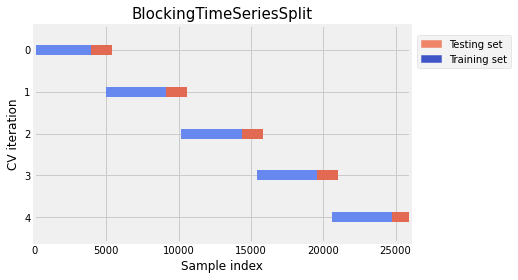

In [35]:
XX = np.arange(25996)
n_split = 5
btscv = BlockingTimeSeriesSplit(n_splits=n_split)
plot_cv_indices(btscv, XX, n_splits=n_split)

In [140]:
#train_y, valid_y, train_x, valid_x = temporal_train_test_split(X=X_data,y=Y_data, test_size=0.1 )
# 0.1 validation :117~121 , ...순서가 잘못됨.
# 0.05 validation :

In [36]:
for i, (train_index, test_index) in enumerate(btscv.split(train_x)):
    print("train : ",train_index)
    print("test : ",test_index)
    print("----")

train :  [   0    1    2 ... 4156 4157 4158]
test :  [4159 4160 4161 ... 5196 5197 5198]
----
train :  [5199 5200 5201 ... 9355 9356 9357]
test :  [ 9358  9359  9360 ... 10395 10396 10397]
----
train :  [10398 10399 10400 ... 14554 14555 14556]
test :  [14557 14558 14559 ... 15594 15595 15596]
----
train :  [15597 15598 15599 ... 19753 19754 19755]
test :  [19756 19757 19758 ... 20793 20794 20795]
----
train :  [20796 20797 20798 ... 24952 24953 24954]
test :  [24955 24956 24957 ... 25992 25993 25994]
----


In [37]:

x_fold_train = []
x_fold_valid = []

y_fold_train = []
y_fold_valid = []


for i, (train_index, test_index) in enumerate(btscv.split(train_x)):
    print("cv:", i+1, "TRAIN:", train_index, "/ TEST:", test_index)
    X_train, X_valid = train_x[train_index], train_x[test_index]
    y_train, y_valid = train_y[train_index], train_y[test_index]
    
    x_fold_train.append(X_train)
    x_fold_valid.append(X_valid)
    
    y_fold_train.append(y_train)
    y_fold_valid.append(y_valid)    
    

cv: 1 TRAIN: [   0    1    2 ... 4156 4157 4158] / TEST: [4159 4160 4161 ... 5196 5197 5198]
cv: 2 TRAIN: [5199 5200 5201 ... 9355 9356 9357] / TEST: [ 9358  9359  9360 ... 10395 10396 10397]
cv: 3 TRAIN: [10398 10399 10400 ... 14554 14555 14556] / TEST: [14557 14558 14559 ... 15594 15595 15596]
cv: 4 TRAIN: [15597 15598 15599 ... 19753 19754 19755] / TEST: [19756 19757 19758 ... 20793 20794 20795]
cv: 5 TRAIN: [20796 20797 20798 ... 24952 24953 24954] / TEST: [24955 24956 24957 ... 25992 25993 25994]


In [143]:
pd.DataFrame(x_fold_train[0][0])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.0,0.0,0.0,2.751439,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66,0.000
1,1.0,0.0,1.0,2.751439,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66,0.000
2,2.0,0.0,2.0,2.926439,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76,0.175
3,3.0,0.0,3.0,2.926439,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53,0.000
4,4.0,0.0,4.0,2.756439,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36,-0.170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,139.0,23.0,1.0,2.061439,-2.37,21.77,34.71,187.02,0.99,0.99,0.99,-0.26,474.46,0.000
716,140.0,23.0,2.0,2.721439,1.52,21.60,34.74,184.73,1.00,1.00,1.00,-0.23,572.31,0.660
717,141.0,23.0,3.0,2.721439,-0.50,21.46,34.24,194.35,0.99,0.99,0.99,-0.26,512.10,0.000
718,142.0,23.0,4.0,1.886439,-1.15,21.35,33.91,192.14,0.99,0.99,0.99,-0.25,416.95,-0.835


In [144]:
pd.DataFrame(y_fold_train[0])

,0,1,2,3,4,5,6,7,8,9,...,278,279,280,281,282,283,284,285,286,287
0,6.12,6.98,8.99,8.50,7.82,6.92,6.24,7.47,7.94,7.20,...,2.63,2.11,2.85,3.42,2.40,2.58,1.97,1.89,2.06,2.80
1,7.12,4.63,5.51,5.05,6.18,3.82,3.31,3.59,1.65,3.24,...,2.53,2.11,1.72,1.80,1.45,1.13,1.28,1.17,0.94,0.74
2,2.53,3.75,2.50,1.47,1.60,2.05,1.76,1.55,1.51,1.90,...,14.41,13.25,13.30,12.43,12.47,12.23,11.90,14.02,14.72,14.59
3,0.67,0.76,0.81,0.67,0.35,0.17,0.29,0.68,0.97,1.08,...,9.82,9.67,9.54,9.81,10.27,9.65,9.87,10.25,10.42,10.69
4,13.51,12.95,13.11,13.47,12.80,12.39,12.37,12.90,12.00,11.25,...,8.98,9.35,9.54,9.84,10.20,10.31,10.91,10.82,10.35,9.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4154,5.84,5.53,5.17,4.84,4.04,2.93,2.80,1.94,1.45,1.44,...,6.47,6.22,6.41,6.96,7.60,7.49,6.82,6.64,7.31,7.39
4155,6.25,6.25,6.69,6.26,6.40,6.22,5.45,5.53,5.22,4.82,...,5.83,6.08,6.82,6.93,7.56,7.79,6.84,6.77,6.21,7.03
4156,6.77,7.08,6.95,6.79,6.50,6.34,6.44,6.30,5.30,5.59,...,9.61,8.31,6.97,7.66,7.28,7.91,7.68,6.18,5.32,5.77
4157,7.24,8.02,8.79,8.55,8.86,8.23,8.59,9.97,9.03,11.06,...,3.34,2.70,2.95,4.04,3.47,3.00,2.21,2.87,2.96,3.34


input dimension은 (Batch, Time_step, Feature dimension) 순이다. (batch_first=True)

output이 288인 이유는 2일이라서

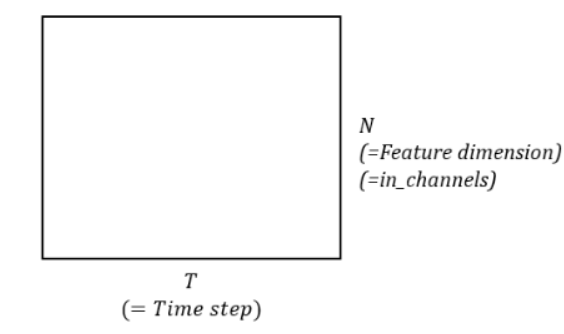

# 데이터 로더

# 데이터 확인

# 모델


### input 설명

- input_size: input의 feature dimension을 넣어주어야 한다. time step이 아니라 feature dimension!
- hidden_size: 내부에서 어떤 feature dimension으로 바꿔주고 싶은지를 넣어주면 된다.
- num_layers: lstm layer를 얼마나 쌓을지
- bias: bias term을 둘 것인가 (Default: True)
- batch_first: batch가 0번 dimension으로 오게 하려면 이거 설정! 난 이거 설정 가정하고 설명했다. (Default: False)
- dropout: 가지치기 얼마나 할지, generalization 잘안되면 이걸 조정하면 된다.
bidirectional: 양방향으로 할지 말지 (bidirectional 하면 [forward, backword] 로 feature dimension 2배 됨)



참고.

https://sanghyu.tistory.com/52

### output 설명

- outputs는 (output, (hidden or hidden stat,cell stat)) 의 tuple 형태로 나오므로 주의해서 써야한다. (LSTM만 cell state있음)
- output: output dimension은 (batch, time_step, hidden dimension) 순이다. 양방향일 경우 hidden_size*2
- hidden state: 모든 layer의 hidden state를 담고있다.
- cell state: 모든 layer의 cell state를 담고있다.

In [91]:
#학습 진행 코드


best_valid_mae_list = []
best_valid_loss_list = []
for data_ind in range(5):
    print("----- {} 차 교차검증 -----".format(data_ind+1))
    check_path = './checkpoint/checkpoint_baseline'+str(data_ind+1)+'.pt'
    print(check_path)
    train_loader,valid_loader = load_data(data_ind)
    
    
    model = BaseModel().to(DEVICE)
    criterion = nn.MSELoss().to(DEVICE)
    metric = nn.L1Loss().to(DEVICE)

    optimizer = torch.optim.Adam(model.parameters(),lr=lr)


    
    best_valid_mae = 999999
    best_valid_loss = 9999999999
    
    early_stopcount = 0

    
    ### test data ###
    
    # 이전 5일치 가져오기.
    test_data_list = [x for x in range(196, 201)]

    test_data = train_data[train_data["Day"].isin(test_data_list)]
    #test_data = test_data[test_data['TurbID']==21]
    #전처리했다면, X_data로 불러와야함.


    test_data = test_data.drop(["TurbID","Day","Wspd_y"], axis = 1)

    test_data = np.array(test_data).reshape(-1, train_x[0].shape[0], train_x[0].shape[1])
    
    test_dataset = TimeDataset(test_data, None)

    test_loader = DataLoader(test_dataset, 
                              batch_size = BATCH_SIZE,
                              shuffle=False)


    
    
    
    ###
    

    for Epoch in range(1,EPOCHS+1):
        train_loss,train_mae = train(model,train_loader,optimizer,log_interval=31)
        valid_loss,valid_mae = evaluate(model, valid_loader)
        
        preds=predict(model,test_loader)
        preds = preds.reshape(-1)
        
        score = test(new_data['Wspd'],preds)
        
        print("\n[EPOCH:{}]\t Train Loss:{:.4f}\t Train MAE:{:.4f}  | \tValid Loss:{:.4f} \tValid MAE: {:.4f}\n test set {:.4f}".
                      format(Epoch, train_loss, train_mae,
                             valid_loss, valid_mae,score))
        
        
        
        if best_valid_mae > valid_mae:
            print("-- SAVE Checkpoint --")
            print("Valid loss : {:.4f} -> {:.4f} \n".format(best_valid_mae,valid_mae ))
            torch.save(model.state_dict(), check_path, _use_new_zipfile_serialization=False)
            best_valid_mae = valid_mae
            best_valid_loss = valid_loss
            early_stopcount=0
        else:
            early_stopcount+=1
        
        if early_stopcount>=5:
            print("----- {} 차 교차검증 ----- early stop.")
            break
            
    best_valid_mae_list.append(best_valid_mae)
    best_valid_loss_list.append(best_valid_loss)
    print("종료.")
        
    
    

----- 1 차 교차검증 -----
./checkpoint/checkpoint_baseline1.pt

[EPOCH:1]	 Train Loss:616.4074	 Train MAE:111.1759  | 	Valid Loss:118.1538 	Valid MAE: 25.4579
 test set 2.8129
-- SAVE Checkpoint --
Valid loss : 999999.0000 -> 25.4579 


[EPOCH:2]	 Train Loss:393.4288	 Train MAE:90.9478  | 	Valid Loss:110.4229 	Valid MAE: 24.5133
 test set 2.6617
-- SAVE Checkpoint --
Valid loss : 25.4579 -> 24.5133 


[EPOCH:3]	 Train Loss:377.5761	 Train MAE:88.8450  | 	Valid Loss:112.9786 	Valid MAE: 24.4513
 test set 2.6139
-- SAVE Checkpoint --
Valid loss : 24.5133 -> 24.4513 


[EPOCH:4]	 Train Loss:368.6785	 Train MAE:87.6412  | 	Valid Loss:113.1338 	Valid MAE: 24.2187
 test set 2.6186
-- SAVE Checkpoint --
Valid loss : 24.4513 -> 24.2187 


[EPOCH:5]	 Train Loss:358.5995	 Train MAE:86.4367  | 	Valid Loss:111.5143 	Valid MAE: 24.1398
 test set 2.6093
-- SAVE Checkpoint --
Valid loss : 24.2187 -> 24.1398 


[EPOCH:6]	 Train Loss:348.8019	 Train MAE:85.1039  | 	Valid Loss:105.6760 	Valid MAE: 23.8533
 t


[EPOCH:6]	 Train Loss:308.5852	 Train MAE:78.4770  | 	Valid Loss:81.2383 	Valid MAE: 21.1942
 test set 2.6648
-- SAVE Checkpoint --
Valid loss : 21.5833 -> 21.1942 


[EPOCH:7]	 Train Loss:296.2917	 Train MAE:76.8500  | 	Valid Loss:75.2172 	Valid MAE: 20.2720
 test set 2.7829
-- SAVE Checkpoint --
Valid loss : 21.1942 -> 20.2720 


[EPOCH:8]	 Train Loss:286.2266	 Train MAE:75.3553  | 	Valid Loss:74.3133 	Valid MAE: 20.0221
 test set 2.7079
-- SAVE Checkpoint --
Valid loss : 20.2720 -> 20.0221 


[EPOCH:9]	 Train Loss:277.5186	 Train MAE:74.1850  | 	Valid Loss:76.3051 	Valid MAE: 20.0393
 test set 2.6980

[EPOCH:10]	 Train Loss:264.2836	 Train MAE:72.1523  | 	Valid Loss:70.2753 	Valid MAE: 19.4915
 test set 2.7594
-- SAVE Checkpoint --
Valid loss : 20.0221 -> 19.4915 


[EPOCH:11]	 Train Loss:251.4235	 Train MAE:70.1967  | 	Valid Loss:65.5143 	Valid MAE: 18.7059
 test set 2.6788
-- SAVE Checkpoint --
Valid loss : 19.4915 -> 18.7059 


[EPOCH:12]	 Train Loss:244.6791	 Train MAE:69.2637 

In [106]:
ddddd

[]

# validation 확인

In [67]:
best_valid_loss_list

[57.89325571060181,
 61.93735074996948,
 33.839824199676514,
 24.66572403907776,
 34.788039207458496]

In [115]:
for i in range(5):
    print("Valid loss : {:.4f} / Valid MAE : {:.4f} \n".format(best_valid_loss_list[i],best_valid_mae_list[i]))

Valid loss : 87.8011 / Valid MAE : 20.3817 



IndexError: list index out of range

In [164]:
print("Valid loss : {:.4f} / Valid MAE : {:.4f} \n".format(best_valid_loss,best_valid_mae))

Valid loss : 0.0589 / Valid MAE : 0.6580 



In [266]:
print("Valid loss : {:.4f} / Valid MAE : {:.4f} \n".format(best_valid_loss,best_valid_mae))

# lstm baseline : Valid loss : 0.3510 / Valid MAE : 2.1029 

Valid loss : 0.0554 / Valid MAE : 0.6800 



# TEST

In [156]:

# 이전 5일치 가져오기.
test_data_list = [x for x in range(196, 201)]

test_data = train_data[train_data["Day"].isin(test_data_list)]
#test_data = test_data[test_data['TurbID']==21]
#전처리했다면, X_data로 불러와야함.


test_data = test_data.drop(["TurbID","Day","Wspd_y"], axis = 1)

test_data = np.array(test_data).reshape(-1, train_x[0].shape[0], train_x[0].shape[1])
#train set 처럼 batch,720,11로 고치기


In [157]:
test_data.shape

(134, 720, 14)